# Calculating time-evolution in Tangelo using discrete clock

This is the notebook that calculates the data used in "Calculating potential energy surfaces with quantum computers by measuring only the
density along adiabatic transitions.".

In [1]:
try:
    import tangelo
except ModuleNotFoundError:
    %pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

try:
    import qulacs
except ModuleNotFoundError:
    %pip install qulacs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tangelo.linq import get_backend, Circuit, Gate
import math
from itertools import product
from openfermion import get_sparse_operator
from tangelo.toolboxes.operators import QubitOperator
import numpy as np
from tangelo.toolboxes.ansatz_generator.ansatz_utils import get_qft_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import pauli_op_to_gate, recursive_trotter_suzuki_decomposition

# Improved multiproduct trotter

Equivalent times are used in 2-step and 6-step trotter for multiproduct trotter evolution. Efficiency in gate decomposition can be implemented as below.

In [3]:
def get_exponentiated_qubit_operator_circuit_new(qubit_op, time=1., variational=False, trotter_order=1, control=None,
                                             return_phase=False, pauli_order=None):
    """Generate the exponentiation of a qubit operator in first- or second-order Trotterized form.
    The algorithm is described in Whitfield 2010 https://arxiv.org/pdf/1001.3855.pdf

    Args:
        qubit_op  (QubitOperator):  qubit hamiltonian to exponentiate
        time (float or dict): The time to evolve the whole system or individiual times for each
            term in the operator. If a dictionary, must have keys that have a matching key in qubit_op.terms
        variational (bool) : Whether the coefficients are variational
        trotter_order (int): order of trotter approximation, only 1 or 2 are supported.
        return_phase (bool): Return the global-phase generated
        pauli_order (list): The desired pauli_word order for trotterization defined as a list of (pauli_word, coeff)
            elements which have matching dictionary elements pauli_word: coeff in QubitOperator terms.items().
            The coeff in pauli_order is used to generate the exponential.

    Returns:
        Circuit: circuit corresponding to exponentiation of qubit operator
        phase : The global phase of the time evolution if return_phase=True else not included
    """
    if pauli_order is None:
        pauli_words = list(qubit_op.terms.items())
    elif isinstance(pauli_order, list):
        pauli_words = pauli_order.copy()
    else:
        raise ValueError("ordered terms must be a list with elements (keys, values) of qubit_op.terms.items()")

    if trotter_order > 1 and trotter_order % 2 != 0:
        raise ValueError(f"odd Trotter order > 1 is not supported currently in Tangelo.")

    timed_pauli_words = recursive_trotter_suzuki_decomposition(pauli_words, trotter_order, time)

    phase = 1.
    exp_pauli_word_gates = list()
    for pauli_word, coef in timed_pauli_words:
        if pauli_word:  # identity terms do not contribute to evolution outside of a phase
            if abs(np.real(coef)) > 1.e-10:
                exp_pauli_word_gates += exp_pauliword_to_gates_special(pauli_word,
                                                               np.real(coef),
                                                               variational=variational,
                                                               control=control)
        else:
            if control is None:
                phase *= np.exp(-1j * np.real(coef))
            else:
                if isinstance(control, int) or len(control) == 1:
                    exp_pauli_word_gates += [Gate("PHASE", target=control, parameter=-np.real(coef), is_variational=variational)]
                else:
                    exp_pauli_word_gates += [Gate("CPHASE", target=0, control=control[:-1], parameter=-2*np.real(coef), is_variational=variational)]
                    exp_pauli_word_gates += [Gate("CRZ", target=0, control=control[:-1], parameter=2*np.real(coef), is_variational=variational)]
                    exp_pauli_word_gates += [Gate("X", control[-1])]
                    exp_pauli_word_gates += [Gate("CPHASE", target=0, control=control, parameter=-4*np.real(coef), is_variational=variational)]
                    exp_pauli_word_gates += [Gate("CRZ", target=0, control=control, parameter=4*np.real(coef), is_variational=variational)]
                    exp_pauli_word_gates += [Gate("X", control[-1])]

    return_value = (Circuit(exp_pauli_word_gates), phase) if return_phase else Circuit(exp_pauli_word_gates)
    return return_value

from typing import Union, List
from tangelo.toolboxes.circuits.grid_circuits import get_xsquared_circuit
def get_psquared_circuit_special(dt: float, dx: float, mass: float, qubit_list: List[int],
                         control: Union[int, List[int]] = None) -> Circuit:
    """Return circuit for p^2/2/m as defined in arXiv:2006.09405 using qft

    Args:
        dt (float): Time to evolve.
        dx (float): Grid spacing.
        mass (float): The mass used for the time-evolution.
        qubit_list (List[int]): Qubits to apply circuit to. The order is important depending on lsq_first or msq_first
        control (Union[int, List[int]]): The control qubits

    Returns:
        Circuit: The circuit that applies exp(-1j*dt*p^2/2/m)
    """
    n_b = 2**len(qubit_list)
    dp = 2*np.pi/n_b/dx
    p0 = n_b//2*dp
    flip_gate = Circuit([Gate('X', target=qubit_list[-1])])
    circuit = Circuit()
    circuit += flip_gate + get_qft_circuit(qubit_list, swap=True) + flip_gate
    circuit += get_xsquared_circuit(dt, dp, 1/2/mass, p0, 0, qubit_list, control=control[:-1])
    circuit += Circuit([Gate("X", control[-1])]) + get_xsquared_circuit(2*dt, dp, 1/2/mass, p0, 0, qubit_list, control=control) + Circuit([Gate("X", control[-1])])
    circuit += flip_gate + get_qft_circuit(qubit_list, inverse=True, swap=True) + flip_gate
    return circuit


def exp_pauliword_to_gates_special(pauli_word, coef, variational=False, control=None):
    """Generate a list of Gate objects corresponding to the exponential of a pauli word.
    The process is described in Whitfield 2010 https://arxiv.org/pdf/1001.3855.pdf

    Args:
        pauli_word (tuple): Openfermion-like tuple that generates a pauli_word to exponentiate
        coef (float): The coefficient in the exponentiation
        variational (bool): When creating the Gate objects, label the (controlled-)Rz gate as variational
        control (integer): The control qubit label

    Returns:
        list: list of Gate objects that represents the exponentiation of the pauli word.
    """
    gates = []

    # Before CNOT ladder
    for index, op in pauli_word:
        if op in {"X", "Y"}:
            gates += [pauli_op_to_gate(index, op, inverse=False)]

    # CNOT ladder and rotation
    indices = sorted([index for index, op in pauli_word])
    cnot_ladder_gates = [Gate("CNOT", target=pair[1], control=pair[0]) for pair in zip(indices[:-1], indices[1:])]
    gates += cnot_ladder_gates

    angle = 2.*coef #if coef >= 0. else 4*np.pi+2*coef
    if control is None:
        gates += [Gate("RZ", target=indices[-1], parameter=angle, is_variational=variational)]
    else:
        gates += [Gate("CRZ", target=indices[-1], control=control[:-1], parameter=angle, is_variational=variational)]
        gates += [Gate("X", control[-1]), Gate("CRZ", target=indices[-1], control=control, parameter=2*angle, is_variational=variational), Gate("X", control[-1])]

    gates += cnot_ladder_gates[::-1]

    # After CNOT ladder
    for index, op in pauli_word[::-1]:
        if op in {"X", "Y"}:
            gates += [pauli_op_to_gate(index, op, inverse=True)]

    return gates


## Defining the system

In [4]:
n_qubits=5
n_pts = 2**n_qubits
dx = 0.6
dt = 0.05
dvrpts = np.linspace(-dx*(n_pts//2-1/2), dx*(n_pts//2-1/2), n_pts)
m = 1
i_pts = np.ones(n_pts)
print(dvrpts)

[-9.3 -8.7 -8.1 -7.5 -6.9 -6.3 -5.7 -5.1 -4.5 -3.9 -3.3 -2.7 -2.1 -1.5
 -0.9 -0.3  0.3  0.9  1.5  2.1  2.7  3.3  3.9  4.5  5.1  5.7  6.3  6.9
  7.5  8.1  8.7  9.3]


In [5]:
lam_eh = 0.7
lam_ee = 0.6
lam_eli = 2.25

def vpot(xpts, r):
    return -1/np.sqrt((xpts-r/2)**2+lam_eh)-1/np.sqrt((xpts+r/2)**2+lam_eli)

def vpot_harm(xpts, r):
    return 1/2*r*xpts**2

def vinteract_harm(xpts):
    n1=len(xpts)
    fullgrid = np.zeros(n1**2, dtype=float)
    for n in range(n1):
        fullgrid[n*n1:(n+1)*n1] = 1/np.sqrt(2+(xpts[n]-xpts)**2)
    return fullgrid

def vinteract(xpts):
    n1=len(xpts)
    fullgrid = np.zeros(n1**2, dtype=float)
    for n in range(n1):
        fullgrid[n*n1:(n+1)*n1] = 1/np.sqrt(lam_ee+(xpts[n]-xpts)**2)
    return fullgrid

def qu_vpot(vals, order='lsq_first'):
    n_qubits=round(math.log2(len(vals)))
    new_vals = vals.copy()
    if order == "msq_first":
        new_vals = new_vals.reshape([2]*n_qubits).transpose(list(reversed(range(n_qubits)))).flatten() 
    v_op =QubitOperator()
    for i in product(["I", "Z"], repeat=n_qubits):
        tup = tuple([(j, op) for j, op in enumerate(i) if op != "I"])
        qu_op = QubitOperator(tup)
        v = get_sparse_operator(qu_op, n_qubits=n_qubits)
        v_op += (diags(new_vals).dot(v)).trace()*QubitOperator(tup)
    v_op /= 2**n_qubits
    return v_op

## Calculation of exact energies and RHF

In [6]:
from scipy.sparse.linalg import eigsh, LinearOperator
from scipy.sparse import diags
from scipy.fft import fft, ifft

vin = vinteract(dvrpts)
v1 = np.kron(1/2*dvrpts**2, i_pts) #np.kron(vpot(dvrpts), i_pts)
#v2 = np.kron(i_pts, vpot(dvrpts))
dp = 2*np.pi/n_pts/dx
p = np.empty(n_pts, dtype=float)
for i in range(n_pts):
    p[i] = dp*i - (n_pts//2)*dp
harm = 1/2*dvrpts**2
vtot = np.diag(harm)
ptot = np.diag(p**2)

def mv(x):
    v = np.zeros(x.shape, dtype=float)
    v = vtot@x
    ftx = fft(np.fft.fftshift(x, 0), x.shape[0], 0, "ortho")
    ftx = 1/2*ptot@np.fft.fftshift(ftx)
    v += np.fft.fftshift(ifft(np.fft.fftshift(ftx), x.shape[0], 0, "ortho")).real
    return v


A = LinearOperator((n_pts, n_pts), matvec = mv)

exact = np.exp(-1/2*dvrpts**2)*np.sqrt(dx)/np.sqrt(np.sqrt(np.pi))

In [7]:
from scipy.linalg import dft
n_pts_s = 8
dx_s = dx*2
dp = 2*np.pi/n_pts_s/dx_s
p = np.empty(n_pts_s, dtype=float)
for i in range(n_pts_s):
    p[i] = dp*i - (n_pts_s//2)*dp
ptot_s = np.diag(p**2)
dvrpts_s = np.linspace(-dx_s*(n_pts_s//2-1/2), dx_s*(n_pts_s//2-1/2), n_pts_s)
dftmat = dft(n_pts_s, 'sqrtn')
p2mat= 1/2*np.diag(ptot_s)
tfft = np.transpose(np.conj(dftmat))@np.diag(p2mat)@dftmat

print(np.linalg.eigh(tfft+np.diag(1/2*dvrpts_s**2))[0])
rval = 0.25
one_body_integrals = np.diag(vpot_harm(dvrpts_s, 1)) + tfft
two_body_coeff = vinteract_harm(dvrpts_s)
two_body_integrals = np.zeros((n_pts_s, n_pts_s, n_pts_s, n_pts_s))
from itertools import product
for i, j in product(range(n_pts_s), repeat=2):
    two_body_integrals[i, j, j, i] = two_body_coeff[i*n_pts_s + j]
    #two_body_tensor[i, j, i, j] = two_body_coeff[i*n_pts_s + j]/2
from openfermion.chem.molecular_data import spinorb_from_spatial
one_body_tensor, two_body_tensor = spinorb_from_spatial(one_body_integrals, two_body_integrals)
from openfermion import InteractionOperator, get_fermion_operator, get_sparse_operator, get_ground_state
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
mol_ham = get_fermion_operator(InteractionOperator(0, one_body_tensor, two_body_tensor/2))
mol_qu = fermion_to_qubit_mapping(mol_ham, "JW", up_then_down=True, n_spinorbitals=16)
#print(mol_qu)
sp_op = get_sparse_operator(mol_qu)
import scipy
#values, vectors = scipy.sparse.linalg.eigsh(sp_op,
#                                                k=100,
#                                                which='SA',
#                                                maxiter=1000)

#print(values)

[ 0.50277254  1.46522161  2.65960569  3.23395861  5.61406764  5.89774492
  9.34213186 10.94859855]


/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/openfermion/chem/molecular_data.py:234: ComplexWarning: Casting complex values to real discards the imaginary part
  one_body_coefficients[2 * p, 2 * q] = one_body_integrals[p, q]
/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/openfermion/chem/molecular_data.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  one_body_coefficients[2 * p + 1, 2 * q +


In [8]:
e, sv = eigsh(A, k =3, which="SA")

Exact energies

In [10]:
rvals = []
evals0 = []
evals1 = []
for r in range(1, 21):
    rval = r*0.25
    v1mat = np.diag(vpot(dvrpts, rval))
    vin = diags(vinteract(dvrpts))

    def mvlih(x):
        xshape = x.shape
        if len(xshape) == 1:
            xshape = [xshape[0], 1]
        xreshape = np.reshape(x, (n_pts, n_pts, xshape[1]))
        v = np.zeros(xreshape.shape, dtype=float)
        v += np.einsum('ij, jkl->ikl', v1mat, xreshape)
        ftx = fft(np.fft.fftshift(xreshape, 0), xreshape.shape[0], 0, "ortho")
        ftx = np.einsum('ij,jkl->ikl', 1/2*ptot, np.fft.fftshift(ftx, 0))
        v += np.fft.fftshift(ifft(np.fft.fftshift(ftx, 0), xreshape.shape[0], 0, "ortho"), 0).real*1.000001

        v += np.einsum('ij, kjl->kil', v1mat , xreshape)
        ftx = fft(np.fft.fftshift(xreshape, 1), xreshape.shape[1], 1, "ortho")
        ftx = np.einsum('ij,kjl->kil', 1/2*ptot, np.fft.fftshift(ftx, 1))
        v += np.fft.fftshift(ifft(np.fft.fftshift(ftx, 1), xreshape.shape[1], 1, "ortho"), 1).real
        if len(x.shape) == 1:
            v = v.flatten()
            return v+vin.dot(x)
        else:
            return np.reshape(v, (n_pts*n_pts, xshape[1]))+vin.dot(x)
        
    A2 = LinearOperator((n_pts**2, n_pts**2), matvec=mvlih)
    e, sv = eigsh(A2, k =2, which="SA")
    #print(rval, e)
    evals0.append(e[0]+ 1/np.sqrt(0.7+2.25-0.6+rval**2))
    evals1.append(e[1]+ 1/np.sqrt(0.7+2.25-0.6+rval**2))
    rvals.append(rval)
print(evals0)

[-1.2763377066126962, -1.2864238408722506, -1.2985190772730268, -1.3090560105161573, -1.3162326667937347, -1.3194253112404124, -1.31847759478919, -1.3138243612129017, -1.3067127900151512, -1.298653651375722, -1.2905664622814852, -1.282671551567292, -1.275156439874261, -1.2685863104765283, -1.2634806818829598, -1.2597393291015284, -1.2568065657270044, -1.2543729613807104, -1.252633390666007, -1.2517699422661486]


Hartree-Fock energies

In [11]:
evalshf = []
for r in range(1, 21):
    rval = r*0.25
    v1mat = np.diag(vpot(dvrpts, rval))
    vin = diags(vinteract(dvrpts))
    vinsquare = np.reshape(vinteract(dvrpts), (n_pts, n_pts))

    vold = np.zeros(n_pts)
    vold1 = np.zeros(n_pts)
    # Hartree fock iterations
    for hf_iter in range(30):
        
    
        def mv1(x):
            v = np.zeros(x.shape, dtype=float)
            v = v1mat@x
            dmat = np.outer(vold, vold)+np.outer(vold1, vold1)
            #v += (vinsquare@(vold**2))*x*2
            #v -= (vinsquare@(x*vold))*vold
            coulomb = vinsquare@(np.diag(dmat))
            exchange = dmat*vinsquare
            v += coulomb*x - 1/2*exchange@x
            ftx = fft(np.fft.fftshift(x, 0), x.shape[0], 0, "ortho")
            ftx = 1/2*ptot@np.fft.fftshift(ftx)
            v += np.fft.fftshift(ifft(np.fft.fftshift(ftx), x.shape[0], 0, "ortho")).real
            return v
        
        A1 = LinearOperator((n_pts, n_pts), matvec=mv1)
        e, sv = eigsh(A1, k =2, which="SA")
        #print(e, np.dot(vold, sv[:,0]))


        vold = sv[:,0].copy()
        vold1 = sv[:,0].copy()

    dmat = np.outer(vold, vold)+np.outer(vold1, vold1)
    #v += (vinsquare@(vold**2))*x*2
    #v -= (vinsquare@(x*vold))*vold
    coulomb = np.diag(vinsquare@(np.diag(dmat)))
    exchange = dmat*vinsquare
    eex = vold.dot(coulomb@vold-1/2*exchange@vold)+vold1.dot(coulomb@vold1-1/2*exchange@vold1)
    evalshf.append(e[0]+e[0]-eex/2+ 1/np.sqrt(0.7+2.25-0.6+rval**2))
    #rvals.append(rval)

Text(0, 0.5, 'Energy (a.u.)')

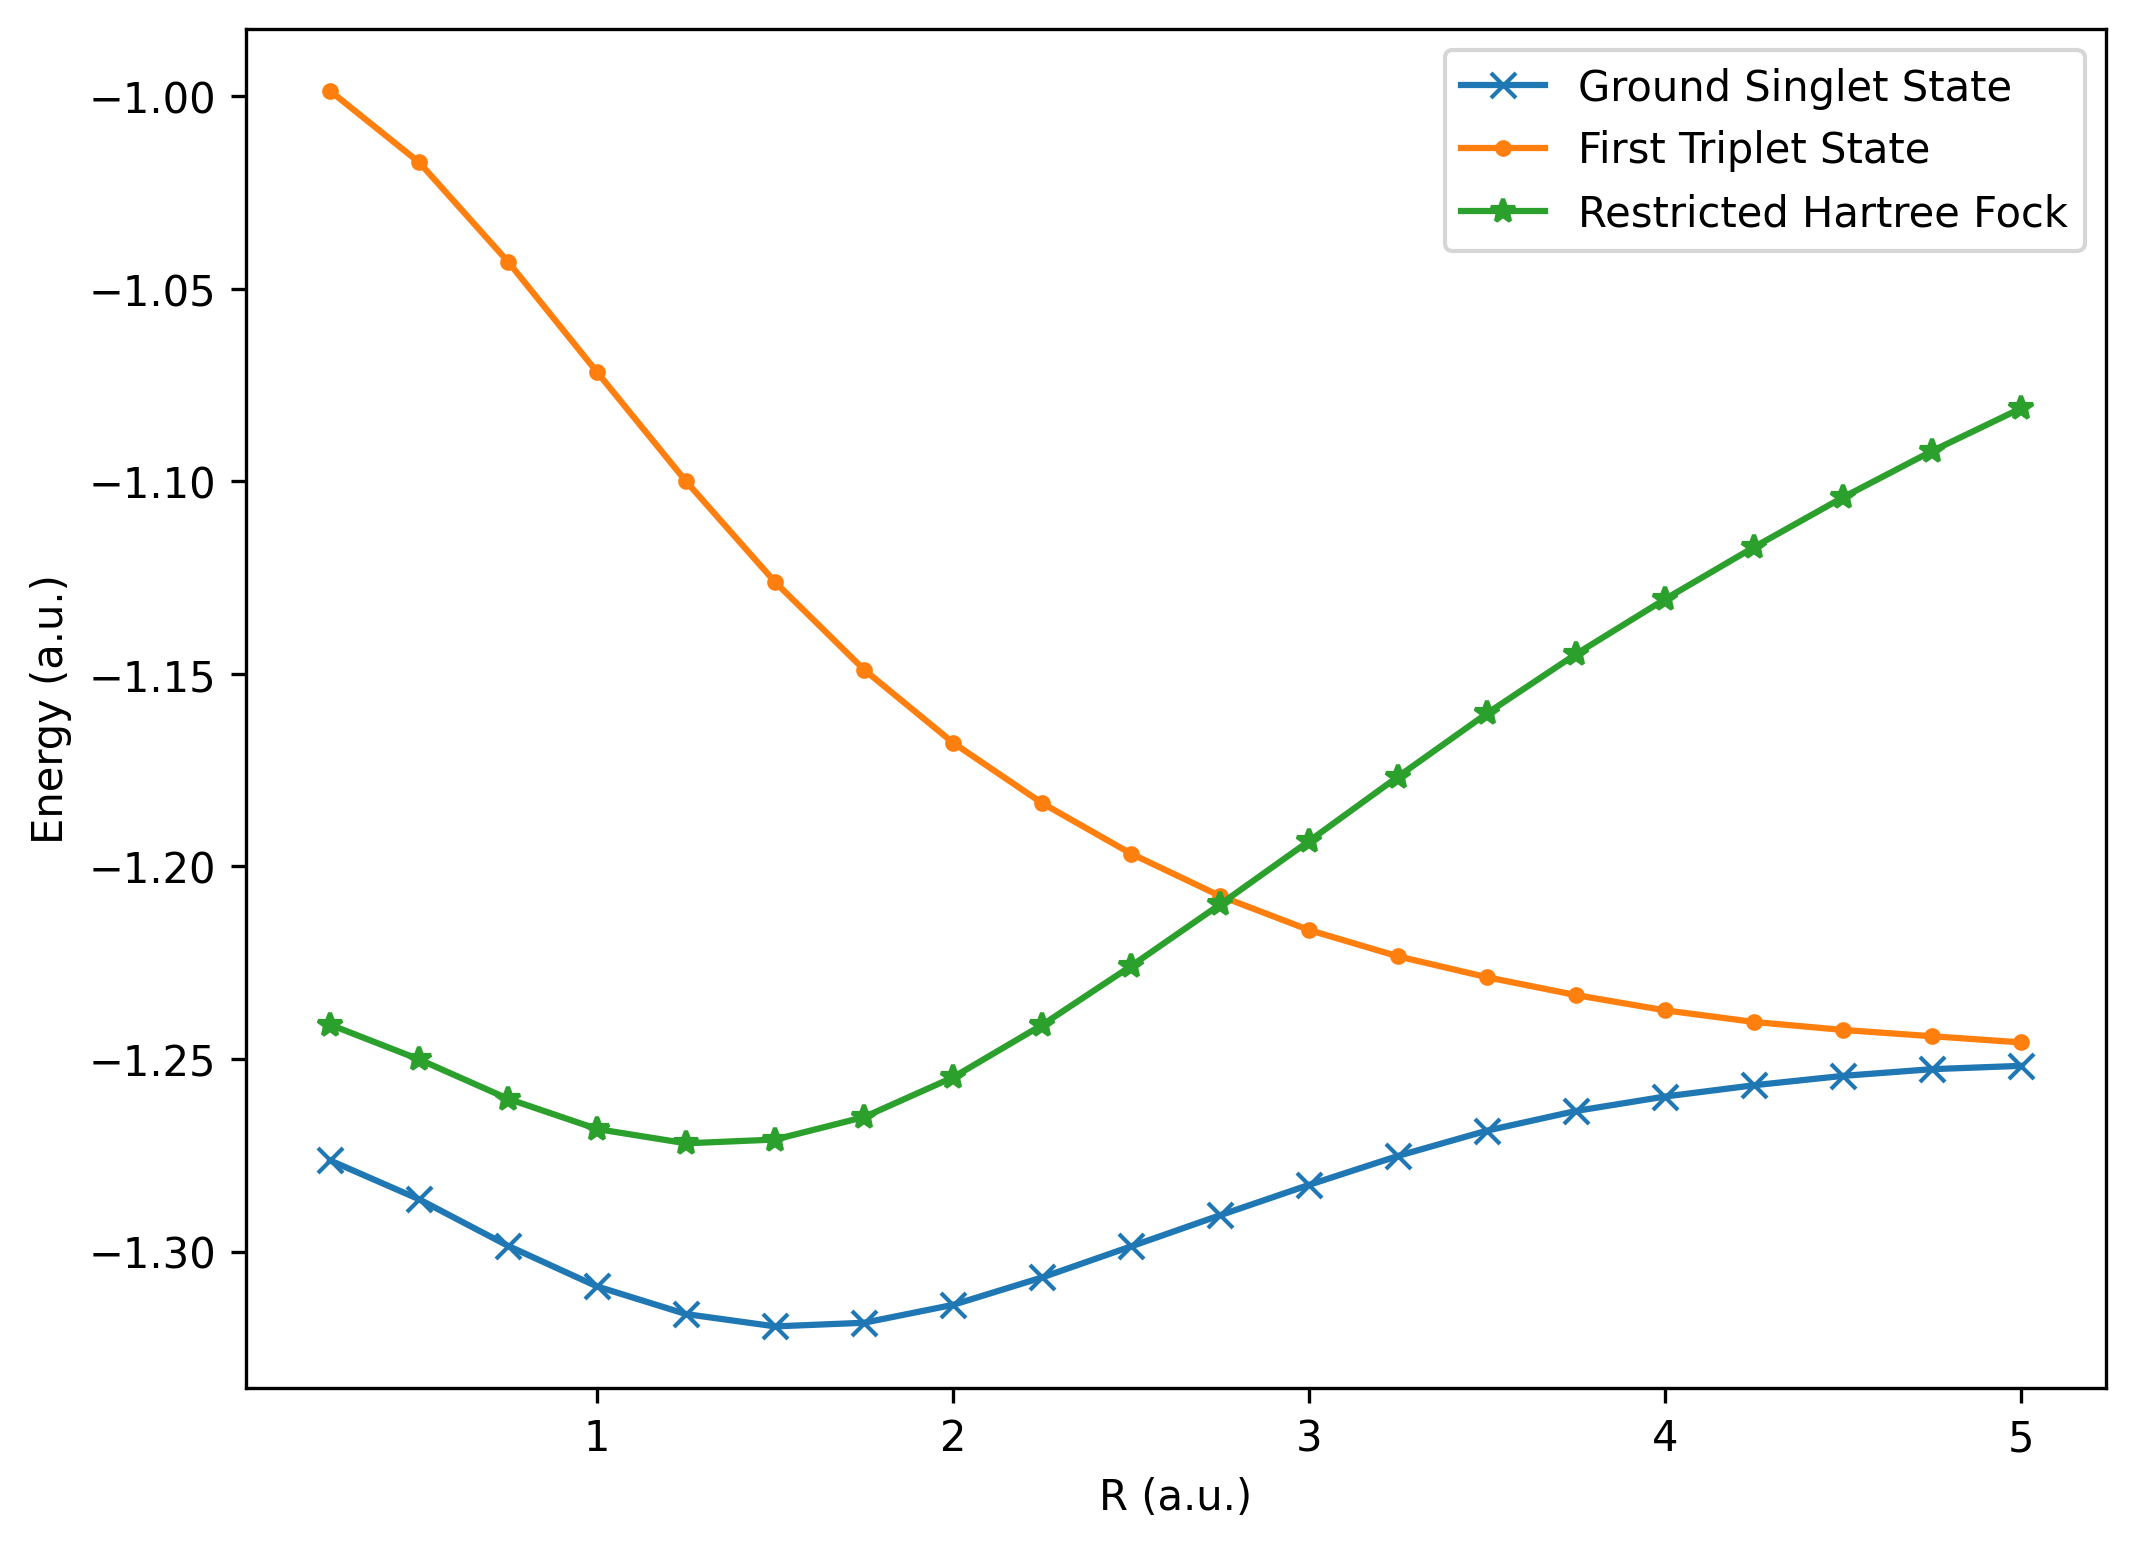

In [12]:
rvals = rvals[0:20]

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(rvals, evals0, 'x-' , rvals, evals1, '.-', rvals, evalshf, '*-')
plt.legend(labels=['Ground Singlet State', 'First Triplet State', 'Restricted Hartree Fock'])
plt.xlabel('R (a.u.)')
plt.ylabel('Energy (a.u.)')

## Quantum simulation

First we calculate the `QubitOperator` representations of the diagonal potential terms

In [13]:
from tangelo.toolboxes.circuits.grid_circuits import get_psquared_circuit
from tangelo.toolboxes.circuits.discrete_clock import get_discrete_clock_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import trotterize

sim = get_backend("qulacs")
statevector_order = sim.backend_info()["statevector_order"]
vint_qu = qu_vpot(vinteract(dvrpts), statevector_order)

In [14]:
vint_circ = trotterize(vint_qu, time=1, variational=True, control=[12, 13])
vint_circ.remove_redundant_gates()
vint_circ2 = get_exponentiated_qubit_operator_circuit_new(vint_qu, time=1, variational=True, control=[12, 13])
vint_circ2.remove_redundant_gates()

Faster to change values of circuit than rebuild. Loop through flagged `_variational_gates`

In [15]:
def change_params(circuit: Circuit, qu_op: QubitOperator, time):
    for i, (term, coeff) in enumerate(qu_op.terms.items()):
        if term:
            circuit._variational_gates[i+1].parameter = 2*coeff.real*time
        else:
            circuit._variational_gates[0].parameter = -2*coeff.real*time
            circuit._variational_gates[1].parameter = 2*coeff.real*time

def change_params_special(circuit: Circuit, qu_op: QubitOperator, time):
    for i, (term, coeff) in enumerate(qu_op.terms.items()):
        if term:
            circuit._variational_gates[2*i+2].parameter = 2*coeff.real*time
            circuit._variational_gates[2*i+3].parameter = 4*coeff.real*time
        else:
            circuit._variational_gates[0].parameter = -2*coeff.real*time
            circuit._variational_gates[1].parameter = 2*coeff.real*time
            circuit._variational_gates[2].parameter = -4*coeff.real*time
            circuit._variational_gates[3].parameter = 4*coeff.real*time

In [16]:
rinit = 0.25
rfin = 0.5

for ri, r in enumerate([rinit, rfin]):
    rval = r
    v1mat = np.diag(vpot(dvrpts, rval))
    vin = diags(vinteract(dvrpts))

    def mvlih(x):
        xshape = x.shape
        if len(xshape) == 1:
            xshape = [xshape[0], 1]
        xreshape = np.reshape(x, (n_pts, n_pts, xshape[1]))
        v = np.zeros(xreshape.shape, dtype=float)
        v += np.einsum('ij, jkl->ikl', v1mat, xreshape)
        ftx = fft(np.fft.fftshift(xreshape, 0), xreshape.shape[0], 0, "ortho")
        ftx = np.einsum('ij,jkl->ikl', 1/2*ptot, np.fft.fftshift(ftx, 0))
        v += np.fft.fftshift(ifft(np.fft.fftshift(ftx, 0), xreshape.shape[0], 0, "ortho"), 0).real*1.000001

        v += np.einsum('ij, kjl->kil', v1mat , xreshape)
        ftx = fft(np.fft.fftshift(xreshape, 1), xreshape.shape[1], 1, "ortho")
        ftx = np.einsum('ij,kjl->kil', 1/2*ptot, np.fft.fftshift(ftx, 1))
        v += np.fft.fftshift(ifft(np.fft.fftshift(ftx, 1), xreshape.shape[1], 1, "ortho"), 1).real
        if len(x.shape) == 1:
            v = v.flatten()
            return v+vin.dot(x)
        else:
            return np.reshape(v, (n_pts*n_pts, xshape[1]))+vin.dot(x)
        
    A2 = LinearOperator((n_pts**2, n_pts**2), matvec=mvlih)
    if ri == 0:
        e, svstart = eigsh(A2, k =2, which="SA")
    else:
        e, sfin = eigsh(A2, k=2, which="SA")

In [17]:
sim = get_backend("qulacs")
statevector_order = sim.backend_info()["statevector_order"]


v1vals = vpot(dvrpts, rinit)
v2vals = vpot(dvrpts, rfin)
qu_v1vals = qu_vpot(v1vals, order=statevector_order)
qu_v2vals = qu_vpot(v2vals, order=statevector_order)
#vec = np.kron(svd[:,0], svd[:, 0])

def pre(ct):
    th = ct/30
    #print(ct, th)
    #return 6*th**5-15*th**4+10*th**3
    return -20*th**7 + 70*th**6 - 84*th**5 + 35*th**4

def trotter_func(t0, time, n_trotter_steps, control, dx, qubit_list, tstart, circ_vint, vint_qu):
    circ = Circuit()
    dt = time/n_trotter_steps
    p2 = get_psquared_circuit(dt/2, dx, 1, qubit_list, control)
    p2.remove_redundant_gates()
    p2_2 = p2.copy()
    p2_2.reindex_qubits(list(range(5, 10))+control)

    if len(circ_vint._variational_gates) != len(vint_qu.terms):
        circ_vint = trotterize(vint_qu, dt, control=control, variational=True)
        circ_vint.remove_redundant_gates()
    else:
        change_params(circ_vint, vint_qu, dt)
    fcirc_gates = []
    for i in range(n_trotter_steps):
        th = t0 + (i+1/2)*dt+tstart
        #v1 = (1-pre(th))*(v1vals) + pre(th)*(v2vals)
        v1 = vpot(dvrpts, 0.25+(rfin-rinit)*pre(th))
        qu_v1 = qu_vpot(v1, statevector_order)
        circ_v1 = trotterize(qu_v1, time=dt, control=control)
        circ_v1.remove_redundant_gates()
        circ_v2 = circ_v1.copy()
        circ_v2.reindex_qubits(list(range(5, 10))+control)
        fcirc_gates += p2._gates + p2_2._gates
        fcirc_gates += circ_vint._gates + circ_v1._gates
        #circ_v1.reindex_qubits(list(range(5, 10))+control)
        fcirc_gates += circ_v2._gates
        fcirc_gates += p2._gates + p2_2._gates
    return Circuit(fcirc_gates)


def trotter_func_special(t0, time, n_trotter_steps, control, dx, qubit_list, tstart, circ_vint, vint_qu, circ_vint2):
    circ = []
    if n_trotter_steps == 1:
        return trotter_func(t0, time, n_trotter_steps, control, dx, qubit_list, tstart, circ_vint, vint_qu)
    elif n_trotter_steps == 2:
        return Circuit() # trotter_func(t0, time, n_trotter_steps, control, dx, qubit_list, tstart, circ_vint, vint_qu)

    dt = time/n_trotter_steps
    if len(circ_vint._variational_gates) != len(vint_qu.terms)+1:
        circ_vint = trotterize(vint_qu, dt, control=control, variational=True)
        circ_vint.remove_redundant_gates()
    if len(circ_vint2._variational_gates) != 2*(len(vint_qu.terms)+1):
        circ_vint2 = get_exponentiated_qubit_operator_circuit_new(vint_qu, dt, control=control, variational=True)
        circ_vint2.remove_redundant_gates()
    #print('control', control)

    qubit_mapping = {i: i+5 for i in range(5)}
    for c in control:
        qubit_mapping[c] = c
    qubit_mappings = {i: i+5 for i in range(5)}
    for c in control[:-1]:
        qubit_mappings[c] = c
    p2 = get_psquared_circuit(dt/2, dx, 1, qubit_list, control)
    p2.remove_redundant_gates()
    p2_2 = p2.copy()
    p2_2.reindex_qubits(list(range(5, 10))+control)#, qubit_mapping)
    p2s_6 = get_psquared_circuit(dt/2, dx, 1, qubit_list, control[:-1])
    p2s_2 = get_psquared_circuit(2*dt/2, dx, 1, qubit_list, control)
    p2s_6.remove_redundant_gates()
    p2s_2.remove_redundant_gates()
    p2s_6_2 = p2s_6.copy()
    p2s_6_2.reindex_qubits(list(range(5, 10))+control[:-1])#, qubit_mappings)
    p2s_2_2 = p2s_2.copy()
    p2s_2_2.reindex_qubits(list(range(5, 10))+control)#, qubit_mapping)

    for i in range(n_trotter_steps):
        th = t0 + (i+1/2)*dt+tstart
        #v1 = (1-pre(th))*(v1vals) + pre(th)*(v2vals)
        v1 = vpot(dvrpts, 0.25+(rfin-rinit)*pre(th))
        qu_v1 = qu_vpot(v1, statevector_order)
        if i not in [1, 4]:
            circ_v1 = trotterize(qu_v1, time=dt, control=control)
            circ_v1.remove_redundant_gates()
            circ_v2 = circ_v1.copy()
            circ_v2.reindex_qubits(list(range(5, 10))+control)#, qubit_mapping)
            circ += p2._gates + p2_2._gates
            change_params(circ_vint, vint_qu, dt)
            circ += circ_v1._gates + circ_v2._gates + circ_vint._gates.copy()
            circ += p2._gates + p2_2._gates
        else:
            circ_v1 = get_exponentiated_qubit_operator_circuit_new(1*qu_v1, time=dt, control=control)
            circ_v1.remove_redundant_gates()
            circ_v2 = circ_v1.copy()
            circ_v2.reindex_qubits(list(range(5, 10))+control)#, new_indices_mapping=qubit_mapping)
            circ += [Gate("X", control[-1])]
            circ += p2s_2._gates + p2s_2_2._gates
            circ += [Gate("X", control[-1])]
            circ += p2s_6._gates + p2s_6_2._gates
            change_params_special(circ_vint2, vint_qu, dt)
            circ += circ_vint2._gates.copy() + circ_v1._gates.copy() + circ_v2._gates.copy()
            circ += p2s_6._gates + p2s_6_2._gates
            circ += [Gate("X", control[-1])]
            circ += p2s_2._gates + p2s_2_2._gates
            circ += [Gate("X", control[-1])]
            
    return Circuit(circ)

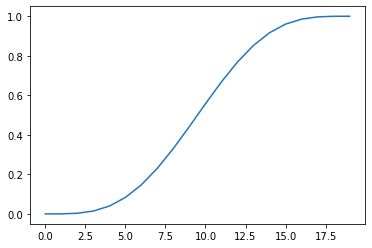

In [18]:
plt.plot(pre(np.linspace(0, 30, 20)))
times = np.linspace(0, 30-30/75, 75)

In [19]:
k=2
from tangelo.toolboxes.circuits.multiproduct import get_multi_product_circuit
qubit_list = list(range(n_qubits))
vint_circ = Circuit()
vint_circ2 = Circuit()
dc_circuit = Circuit()
dc_circuits = [Circuit(n_qubits=13)]
for t in times:
    print(t)
    dc_circuits.append(get_multi_product_circuit(0.4, 3, 10, second_order_trotter=trotter_func_special,
                                            trotter_kwargs={"t0": 0, "time": 0.4, "dx": dx, "qubit_list": qubit_list, "tstart": t,
                                                             "circ_vint": vint_circ, "vint_qu": vint_qu, "circ_vint2": vint_circ2}))

0.0
0.4
0.8
1.2000000000000002
1.6
2.0
2.4000000000000004
2.8000000000000003
3.2
3.6
4.0
4.4
4.800000000000001
5.2
5.6000000000000005
6.0
6.4
6.800000000000001
7.2
7.6000000000000005
8.0
8.4
8.8
9.200000000000001
9.600000000000001
10.0
10.4
10.8
11.200000000000001
11.600000000000001
12.0
12.4
12.8
13.200000000000001
13.600000000000001
14.0
14.4
14.8
15.200000000000001
15.600000000000001
16.0
16.400000000000002
16.8
17.2
17.6
18.0
18.400000000000002
18.8
19.200000000000003
19.6
20.0
20.400000000000002
20.8
21.200000000000003
21.6
22.0
22.400000000000002
22.8
23.200000000000003
23.6
24.0
24.400000000000002
24.8
25.200000000000003
25.6
26.0
26.400000000000002
26.8
27.200000000000003
27.6
28.0
28.400000000000002
28.8
29.200000000000003
29.6


0.9999999988188145


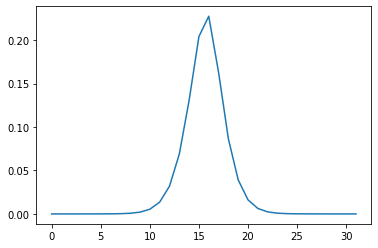

In [20]:
from tangelo.toolboxes.post_processing.histogram import Histogram
#################################
svpost = svstart[:,0]
n_ancilla = 2**3
zero = np.zeros(n_ancilla)
zero[0]=1
start = np.kron(zero, svpost)
svold = start.copy()
dens = []
for circ in dc_circuits:
    f, svnew = sim.simulate(circ, initial_statevector=svold, return_statevector=True)
    hist = Histogram(f)
    hist.post_select({10: "0", 11: "0", 12: "0"})
    hist.remove_qubit_indices(*list(range(5,10)))
    freq_post = hist.frequencies
    densc = np.zeros(n_pts)
    for key, value in freq_post.items():
        densc[int(key[::-1], base=2)] = value
    dens.append(densc)
    svold = svnew.copy()
plt.plot(densc)
svpost = np.reshape(svold , (n_ancilla, n_pts**2))[0, :]
print(np.linalg.norm(svpost))

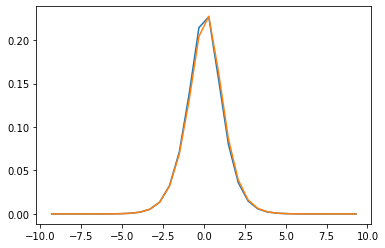

In [49]:
plt.plot(dvrpts, dens[0], dvrpts, dens[-1])
plt.legend(["initial density"], ["final density"])

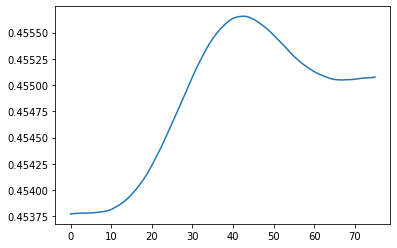

In [50]:
den18 = [dens[i][16] for i in range(len(dens))]
plt.plot(2*np.array(den18))

In [51]:
for r in range(1, 2):
    rval = rfin*r
    v1mat = np.diag(vpot(dvrpts, rval))
    vin = diags(vinteract(dvrpts))

    def mvlih(x):
        xshape = x.shape
        if len(xshape) == 1:
            xshape = [xshape[0], 1]
        xreshape = np.reshape(x, (n_pts, n_pts, xshape[1]))
        v = np.zeros(xreshape.shape, dtype=float)
        v += np.einsum('ij, jkl->ikl', v1mat, xreshape)
        ftx = fft(np.fft.fftshift(xreshape, 0), xreshape.shape[0], 0, "ortho")
        ftx = np.einsum('ij,jkl->ikl', 1/2*ptot, np.fft.fftshift(ftx, 0))
        v += np.fft.fftshift(ifft(np.fft.fftshift(ftx, 0), xreshape.shape[0], 0, "ortho"), 0).real

        v += np.einsum('ij, kjl->kil', v1mat , xreshape)
        ftx = fft(np.fft.fftshift(xreshape, 1), xreshape.shape[1], 1, "ortho")
        ftx = np.einsum('ij,kjl->kil', 1/2*ptot, np.fft.fftshift(ftx, 1))
        v += np.fft.fftshift(ifft(np.fft.fftshift(ftx, 1), xreshape.shape[1], 1, "ortho"), 1).real
        if len(x.shape) == 1:
            v = v.flatten()
            return v+vin.dot(x)
        else:
            return np.reshape(v, (n_pts*n_pts, xshape[1]))+vin.dot(x)
        
    A2 = LinearOperator((n_pts**2, n_pts**2), matvec=mvlih)
    e, svfin = eigsh(A2, k =2, which="SA")

overlap of final state with exact R=0.5 wavefunction =  0.9999983051551147


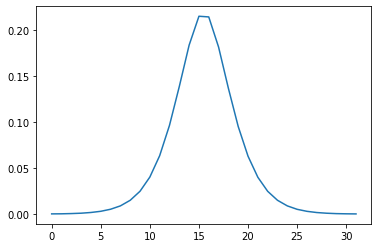

In [53]:
st = n_pts*n_pts//2
fi = n_pts*n_pts//2 + n_pts
#print(svpost[st:fi]/svfin[st:fi,0])
print('overlap of final state with exact R=0.5 wavefunction = ', np.abs(svpost.dot(svfin[:,0])))
plt.plot(np.abs(svpost[st:fi]))

In [ ]:
import pandas as pd
dfd = pd.DataFrame(dens)
dft = pd.DataFrame(list(times)+[30.])

dfd.to_csv('dens_qc.csv')
dft.to_csv('times_qc.csv')
